In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json
import glob

In [2]:
# Built on Peter and Lynne's original notebooks:
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# Set up variables and get the first year of observations

In [3]:
# select the survey simulation
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

# range of nights to investigate (year 1 of survey)
night_min = 0
night_max = 365

In [4]:
# set nside for analysis metric (use higher resolution when removing no-template images later)
nside = 32
# nside = 256
s_hp = maf.HealpixSlicer(nside=nside)

# make a time slicer
nights = np.arange(night_min, night_max+1, 1)
s_t = maf.OneDSlicer(sliceColName="night", bins = nights)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [5]:
# set path for metric output files
save_dir = "remove_no_template_results_{}".format(nside)

In [6]:
# use the healpix area to find approximate number of healpixels in a single visit
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees
lsst_footprint = 9.6 # square degrees, GET EXACT NUMBER?
n_pix = lsst_footprint/pix_area # number of healpixels within each visit footprint
print("healpixel area = {} square degrees\n number of healpixels in visit = {}".format(pix_area,n_pix))

healpixel area = 3.357174580844667 square degrees
 number of healpixels in visit = 2.8595474464675097


In [7]:
# Set some fraction of visit covered by template required to be analysed
frac = 0.9

In [8]:
# Choose to ignore deep drilling fields 
# This string will be applied to metric sql query and also to the redacted database code
# sqlDD = ''
sqlDD = ' and note not like "%DD%"'

if sqlDD!='':
    save_dir+="_noDD" # change the save directory
    
print(save_dir)

remove_no_template_results_32_noDD


In [9]:
# query or load the database of year 1 observations
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<=night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

In [10]:
# set up some filenames
opsim_fname = year1_fname
print(opsim_fname)
opsdb = maf.OpsimDatabase(opsim_fname)
runName = os.path.split(opsdb)[-1].replace('.db', '')
print(runName)

first_year_baseline_v3.0_10yrs.db
first_year_baseline_v3.0_10yrs


In [11]:
# template generation timescales to test
tscales = [28,28*4,28*6]

# store the timescale and template generation nights in a dict
template_timescales = {}

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,night_max+tscale,tscale)
    template_nights[-1] = night_max # consider only the first year
        
    template_timescales[str(tscale)] = template_nights
    
template_timescales

{'28': array([  0,  28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336,
        364, 365]),
 '112': array([  0, 112, 224, 336, 365]),
 '168': array([  0, 168, 336, 365])}

# Remove visits without templates using Peter's code

Add Lynne's requirements on image quality when counting number of available images to generate template with.

Peter's code assumes that a template will be generated once, on a given night.

In [12]:
# new base class. We might consider moving this into BaseMetric, or maybe doing this in the slicer instead.
class BaseTemplateMetric(maf.metrics.BaseMetric):
    """Make a new base class that will filter out observation from before we have templates available
    """
    def __init__(self,
                col=None,
                n_visits_for_template=3., # note that this is float
                night_template_min=182,
                mjdCol='observationStartMJD',
                nightCol='night',
                filterCol='filter',
                 seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 **kwargs):
        if col is None:
            col = []
        else:
            col = [col]
        col += [mjdCol, nightCol, filterCol]
        super().__init__(col=col, **kwargs)
        self.n_visits_for_template = n_visits_for_template
        self.night_template_min = night_template_min
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        
        # this snippet (from Lynne nb) is required to set the columns that need to be called when running the metric
        if 'metricName' in kwargs:
            self.metricName = kwargs['metricName']
            del kwargs['metricName']
        else:
            self.metricName = 'BaseTemplateMetric'
        super().__init__(col=[self.mjdCol, self.seeingCol, self.m5Col, self.nightCol, self.filterCol], 
                         metricName=self.metricName, **kwargs)
        
        print("night_template_min = {}, seeing_ratio = {}, m5_range = {}".format(self.night_template_min,self.seeing_ratio,self.m5_range))
        
    def _remove_no_template_visits(self, dataSlice):
        
        dataSlice.sort(order=self.mjdCol)
        
        n_visits = int(self.n_visits_for_template) # number of good images required for template
        
        # Apply the masks to remove images not suitable for templates/science
        # everything starts as true and is switched to false if required
        has_template_indx = np.ones(dataSlice.size, dtype=bool) # science images with templates
        template_img_indx = np.ones(dataSlice.size, dtype=bool) # images used for templates
        
        # template images must have been taken before the generation date
        template_time = np.where(dataSlice[self.nightCol] < self.night_template_min,
                        True, False)
        # science images can only be counted after the generation date
        image_time = np.where(dataSlice[self.nightCol] > self.night_template_min,
                        True, False)
        ### should use a greater than sign for nights here? Or allow leeway for template generation time?
        
        # define list of possible science/template images by removing impossible images
        has_template_indx[~(image_time)] = False
        template_img_indx[~(template_time)] = False
        
#         print(self.night_template_min,len(dataSlice),sum(template_img_indx),sum(has_template_indx))
        
        # look at each dataslice by filter, because template images must be in the same filter
        for filtername in np.unique(dataSlice[self.filterCol]):
            
            # mask for each filter
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0] # index zero required to get just the mask (or use True, False arguments like Lynne above)
            # mask for template images in the filter
            infilt_templates = infilt & template_time[infilt]
            
            # What if there are zero template images in this filter?
            if sum(infilt_templates)==0:
                has_template_indx[infilt] = False # there can be no science images
                continue

            # Find the best seeing and depth in the available template images
            bench_seeing = np.min(dataSlice[infilt_templates][self.seeingCol])
            bench_m5 = np.max(dataSlice[infilt_templates][self.m5Col])
            
            # define the masks for template visits in this filter meeting the seeing/depth requirements
            seeing_ok = np.where(dataSlice[infilt_templates][self.seeingCol]/bench_seeing < self.seeing_ratio, 
                                True, False) 
            m5_ok = np.where(bench_m5 - dataSlice[infilt_templates][self.m5Col] < self.m5_range,
                            True, False)
            
            # define list of images that are suitable for generating templates by removing "bad" visits
            # N.B. we have accounted for the template generation night above
            template_img_indx[infilt][~(seeing_ok & m5_ok)] = False
        
            # check if there are is a sufficent number of images for making the templates
            # if not, no science images can be counted in this healpixel (until next template generation time)
            if sum(template_img_indx[infilt])<n_visits:
                has_template_indx[infilt] = False
                
#         print(sum(has_template_indx))

        # return the mask of science images with templates and the mask of template images
        return has_template_indx, template_img_indx


In [13]:

# OK, now let's write a function that takes a bunch of observations in, 
# then cuts out ones that probably don't have template images

# Class that will return all the id's that we think have templates generated
class HasTemplateIndx(BaseTemplateMetric):
    """Return the obIds that probably have templates
    This then allows you to run metrics directly on the visits of the dataslice 
    that had templates and could generate alerts
    """
    def __init__(self, col='observationId', metricDtype="object", **kwargs):
        super().__init__(col=col, metricDtype=metricDtype, **kwargs)
        self.idCol = col
    def run(self, dataSlice, slicePoint=None):
        has_template_indx, template_img_indx = self._remove_no_template_visits(dataSlice) # get the mask of science images
        dataSlice = dataSlice[has_template_indx] # apply the mask to the dataSlice
        return dataSlice[self.idCol]

In [14]:

def remove_no_templates(data_in, nside=32, id_col='observationId',
                        night_template_min = 182,
                        template_col = "npix_template", # column name to store fraction of visit covered by template
                        **kwargs):
    """
    This function removes all visits from data_in that had zero template coverage.
    data_in is some chunk of year 1 with visits between times of template generation.
    Visits that had a template for at least one of its constituent healpixels are retained.
    We add a new column that records the number of healpixels with templates within each visit.
    """
    
    slicer = maf.slicers.HealpixSlicer(nside=nside, verbose=False)
    metric = HasTemplateIndx(night_template_min = night_template_min, **kwargs)
    print("night_template_min = {}".format(metric.night_template_min))
    sql=None
    bundle = maf.MetricBundle(metric, slicer, sql)
    mbg = maf.MetricBundleGroup([bundle], None, saveEarly=False,
                                verbose=False)
    mbg.runCurrent(None, simData=data_in)
    
    # we retrieve an array with the id_col (observationId) of every single visit 
    # that had at least one constituent healpixel with a template
    # An id_col value can appear multiple times as there are multiple healpixels within each visit
    all_vals = np.concatenate(bundle.metricValues.data[~bundle.metricValues.mask])

    # we find all unique id_col, these are the visits that had some form of template
    # we count the number of each unique id_col, this is the number of healpixels within the visit that had templates
    valid_ids,count_ids = np.unique(all_vals,return_counts=True)
#     print(valid_ids,count_ids)

    # keep only visits with templates
    indx = np.in1d(data_in[id_col], valid_ids)
    result = data_in[indx]
    ### ALSO KEEP VISITS WHERE TEMPLATE_COL = 0?
    
    # add a column to track number of healpixels with templates within visits 
    # ONLY for visits that had at least one template
    result[template_col] = count_ids
  
    # return the database of visits with templates
    return result

# Run metrics on dataslice directly

In [15]:
class doAllTemplateMetrics(BaseTemplateMetric):
    
    # run all the metrics on dataSlice so that the the removal of visits only occurs once
    
    def __init__(self, col='observationId', **kwargs):
        # ensure all kwargs are passed to teh template class (e.g. night_template_min)
        super().__init__(col=col, **kwargs)
        self.idCol = col
        
    def run(self, dataSlice, slicePoint=None):

        # run the template checking code to create a dataSlice with only the visits with templates
        has_template_indx, template_img_indx = self._remove_no_template_visits(dataSlice) # get the mask of science images

        # return a list of both dataSlices, one with science images, one with template images
        # Also pass the dataslice of first night of all the visits in that healpixel
        return [dataSlice[has_template_indx],
                dataSlice[template_img_indx],
                dataSlice[0]] # This list is stored as metricVal
    
    def reduceCount(self,metricVal):
        """
        Count the number of visits with existing templates within each healpix
        When grouping take the sum
        """
        sci_img = metricVal[0] # science images
        count = len(sci_img)
        if count==0:
            count = self.badval # set badval to help with metric plotting later
        return count
        
### Move this one to a separate metric as we want to constrain the pairs of filters
#     def reducePairs(self,metricVal):
#         # Get the number of pairs available in each healpix
#         # When grouping take the sum

#         x = metricVal[0] # science images
#         if len(x)==0:
#             pairs = self.badval
#         else:
#             pairs = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName='Pairs').run(x)
#         return pairs
    
    def reduceNight(self,metricVal):
        """
        Get the first possible night when templates are available
        Note that this should not count beyond the template generation night
        When grouping select the minimum value
        """

        sci_img = metricVal[0] # science images
        temp_img = metricVal[1] # dataSlice of template images

        # N.B. there is a subtlety between counting when the first science images appear and when the template is first available
#         if (len(sci_img)==0):
        if (len(temp_img)<int(self.n_visits_for_template)): # only count if there are enough images 

            night = self.badval
        else:
            # if there is at least one healpixel which satisifies templates
            # then we can say that the template was made on at least the template generation night
            night = self.night_template_min                
        return night
    
    def reduceDeltaNight(self, metricVal):
        """ 
        This metric returns time since the first visit for the first template to be available.
        Different to Lynne's implementation which did not account for filters.
        
        When grouping select the first non-badval number (or minimum?)
        """
        
        sci_img = metricVal[0] # dataSlice of science images
        temp_img = metricVal[1] # dataSlice of template images
        first_night = metricVal[2][self.nightCol] # first night of visit

#         # This version of the metric ignores the template generation timescale, to account for distinct nights:
#         # metric_plot = np.ceil(metric_plot/template_timescale)*template_timescale
#         if (len(temp_img)>=int(self.n_visits_for_template)):
#             dn = temp_img[self.nightCol][int(self.n_visits_for_template)-1] - first_night
#         else:
#             dn = self.badval
            
        # This version of the metric rounds (up) to the template generation night
        # i.e. the night of possible template generation (temp_img[self.nightCol][int(self.n_visits_for_template)-1])
        # is probably less then night_template_min
        if (len(temp_img)>=int(self.n_visits_for_template)):
#         if (len(sci_img)>0): # science images exist
            dn = self.night_template_min - first_night
#             dt = self.night_template_min - temp_img[self.nightCol][0] # optional, get time range of just the template images, basically the same as above

        else:
            dn = self.badval

        return dn
        
    def reduceNTemplate(self,metricVal):
        """
        Returns the total number of images used to make a template.
        When grouping results, take the first non-badval number (or minimum?)
        """
        
        sci_img = metricVal[0] # dataSlice of science images
        temp_img = metricVal[1] # dataSlice of template images
        if (len(temp_img)>=int(self.n_visits_for_template)): # only count if there are enough template images 
#         if (len(sci_img)>0): # science images exist
            NTemplate = len(temp_img) # count total number of templates
        else:
            NTemplate = self.badval
        return NTemplate
    
    def reduceSeeingTemplate(self,metricVal):
        """
        Returns the mean seeing of images used to make a template.
        When grouping results, take the mean (accounting for badvals?)
        """

        sci_img = metricVal[0] # dataSlice of science images
        temp_img = metricVal[1] # dataSlice of template images
        if (len(temp_img)<int(self.n_visits_for_template)): # only count if there are enough images 
#         if (len(sci_img)==0): # no science images exist
            seeing = self.badval
        else:
            seeing = np.mean(temp_img[self.seeingCol]) # calculate the mean seeing
        return seeing
    
    def reduceDepthTemplate(self,metricVal):
        """
        Returns the mean depth of images used to make a template.
        When grouping results, take the mean (accounting for badvals?)
        """

        sci_img = metricVal[0] # dataSlice of science images
        temp_img = metricVal[1] # dataSlice of template images
        if (len(temp_img)<int(self.n_visits_for_template)): # only count if there are enough images 
#         if (len(sci_img)==0): # no science images exist
            depth = self.badval
        else:
            depth = np.mean(temp_img[self.m5Col]) # calculate the mean depth
        return depth
    
    ### additional metrics
    # date range of first n_visits_for_template template images? 
    # As we increase template generation timescale this will become the same as reduceDeltaNight


In [16]:
class doPairTemplateMetrics(BaseTemplateMetric):
    
    # run all the metrics on dataSlice so that the the removal of visits only occurs once
    
    def __init__(self, col='observationId', **kwargs):
        # ensure all kwargs are passed to teh template class (e.g. night_template_min)
        super().__init__(col=col, **kwargs)
        self.idCol = col
        
    def run(self, dataSlice, slicePoint=None):

        # run the template checking code to create a dataSlice with only the visits with templates
        has_template_indx, template_img_indx = self._remove_no_template_visits(dataSlice) # get the mask of science images

        # return a list of both dataSlices, one with science images, one with template images
        # Also pass the first night of all the visits
        return [dataSlice[has_template_indx],
                dataSlice[template_img_indx],
                dataSlice[0]] # This list is stored as metricVal
        
    def reducePairs(self,metricVal):
        # Get the number of pairs available in each healpix, for any combination of the queried filters
        # When grouping take the sum

        x = metricVal[0] # science images
        if len(x)==0:
            pairs = self.badval
        else:
            pairs = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName='Pairs').run(x)
        return pairs


Querying table None with constraint filter = "i" and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 51215 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_i_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_i_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "z" and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 38481 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_z_and_night_l

/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Found 47662 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint (filter = "r" or filter = "z") and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Found 86143 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 9864 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_u_and_night_lt_365_and_note_not_like_DD_HEAL']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_u_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Found 209367 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint (filter = "r" or filter = "g") and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Found 62457 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 47350 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_y_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_y_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint (filter = "r" or filter = "i") and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Found 98877 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 365 and note not like "%DD%" for columns ['rotSkyPos', 'night', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 14795 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_g_and_night_lt_365_and_note_not_like_DD_HEAL']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)
0.0 180.0 -180.0 180.0


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_g_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "i" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "z" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "r" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "(filter = "r" or filter = "z") and night <= 365 and note not like "%DD%"" constraint now.


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/plots/spatialPlotters.py:192: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(fignum, figsize=plotDict["figsize"])
0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "u" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "(filter = "r" or filter = "g") and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "y" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "(filter = "r" or filter = "i") and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "g" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(


Plotting complete.
89.85463500022888s (1.497577min or 0.024960hrs)


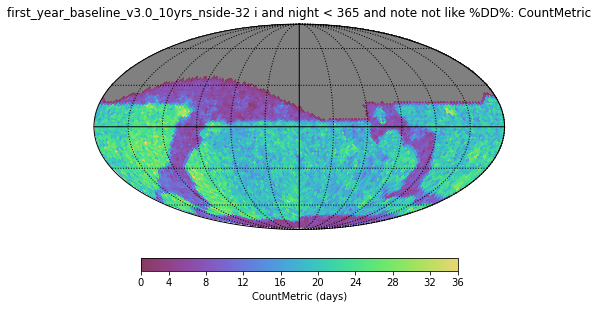

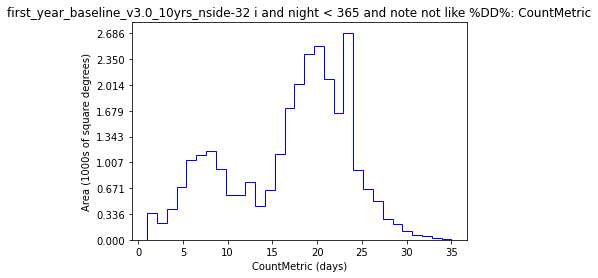

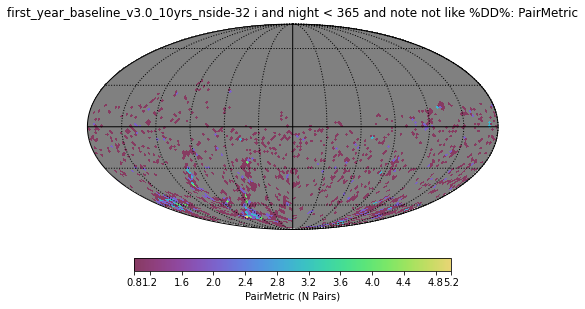

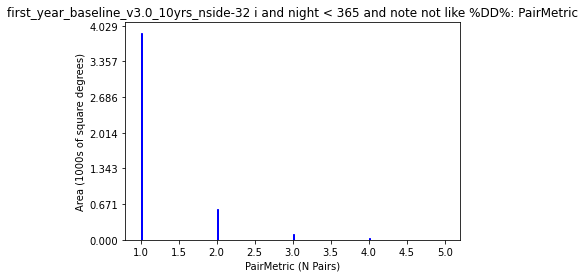

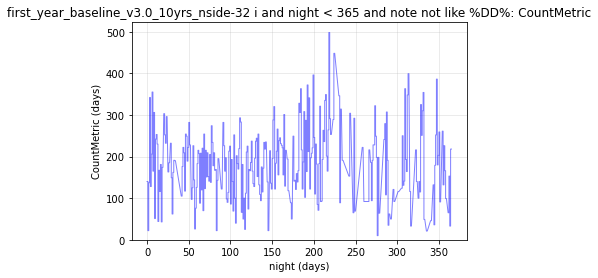

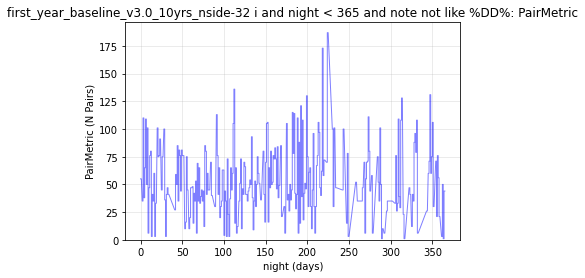

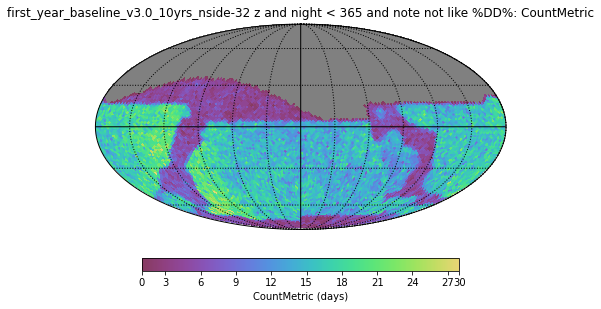

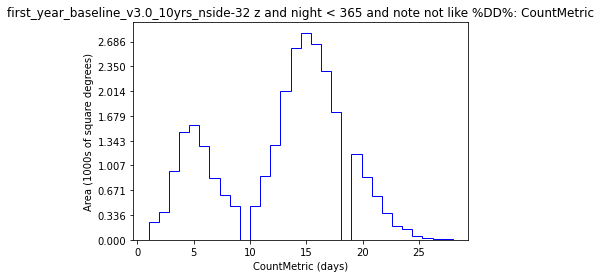

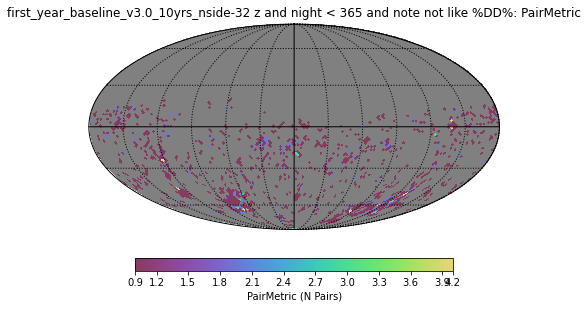

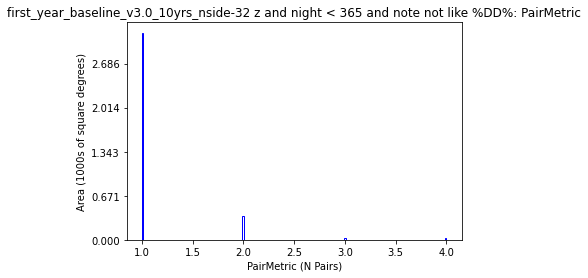

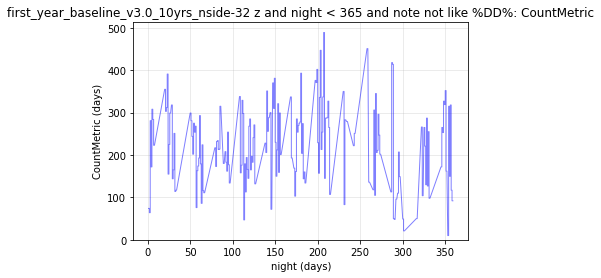

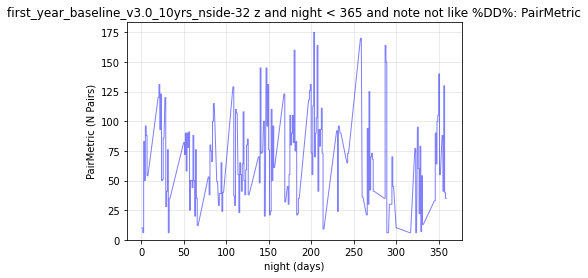

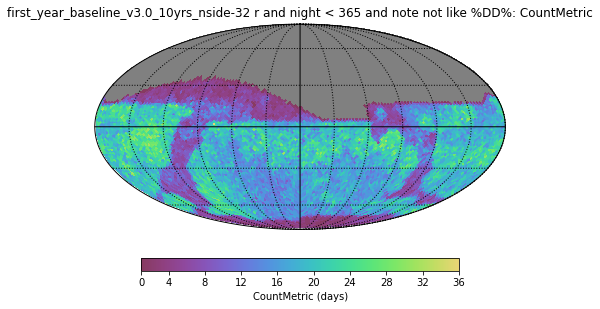

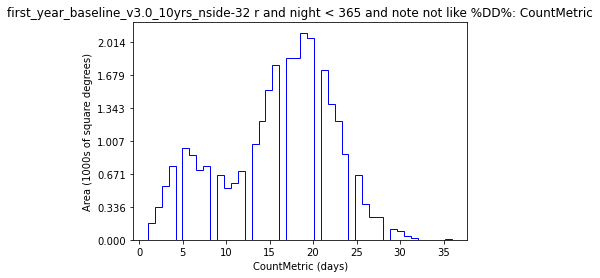

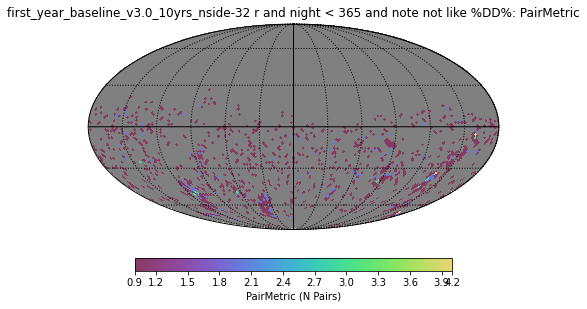

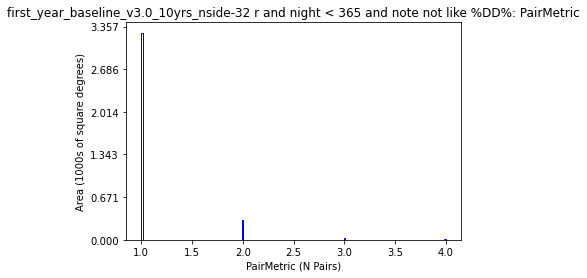

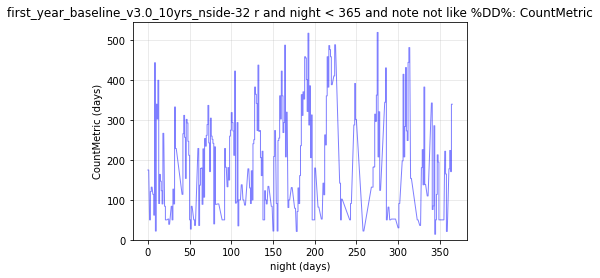

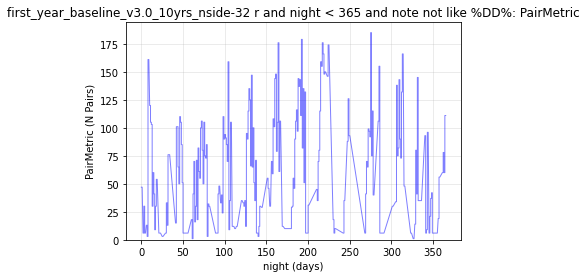

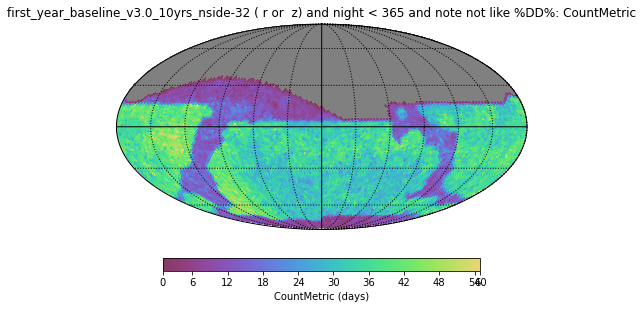

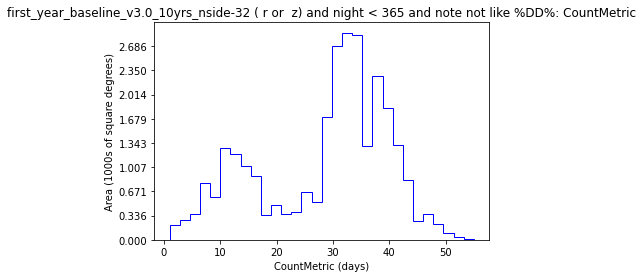

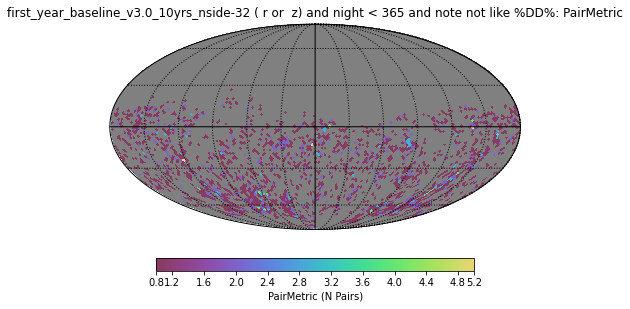

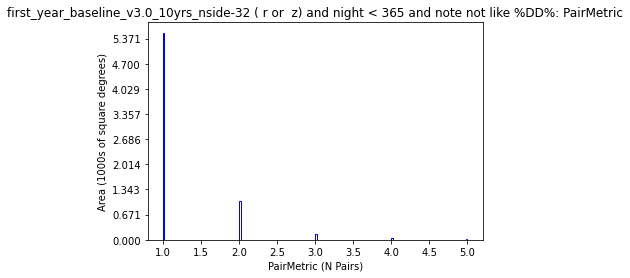

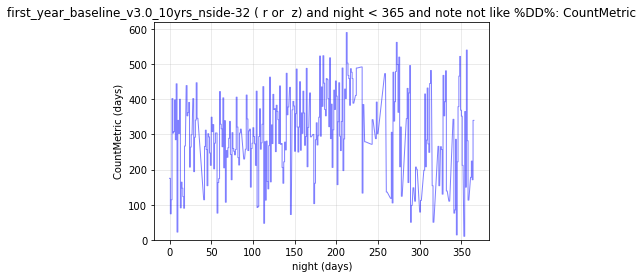

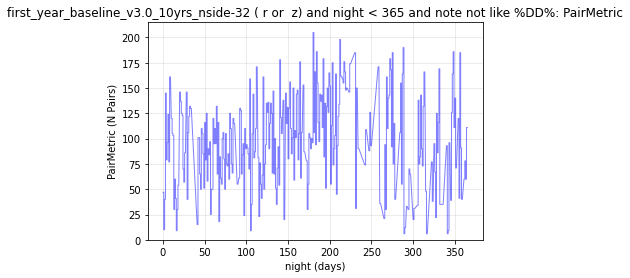

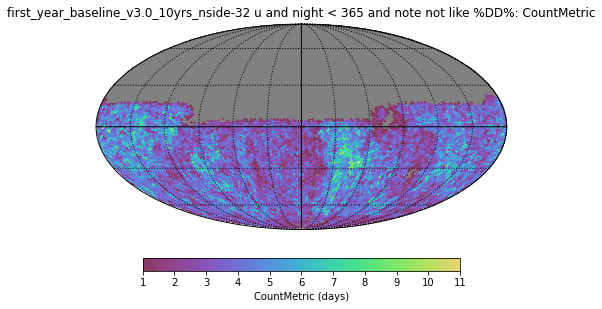

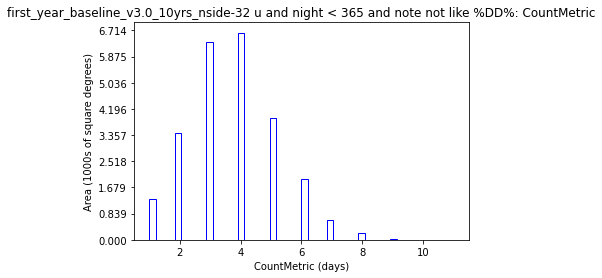

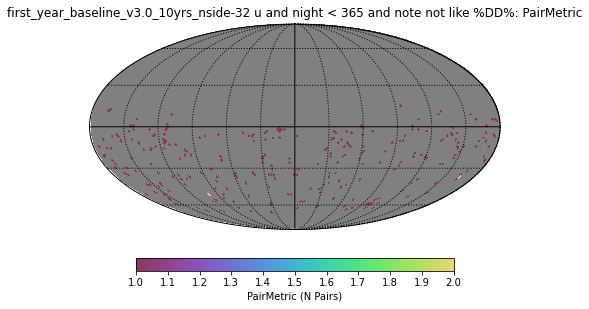

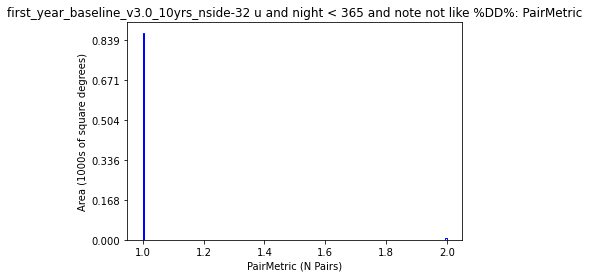

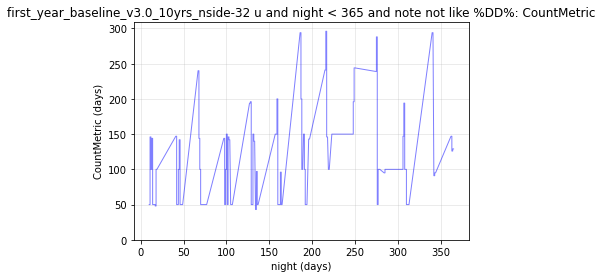

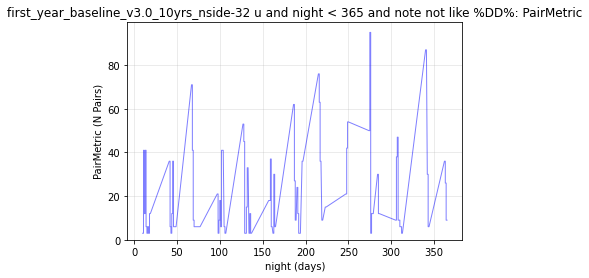

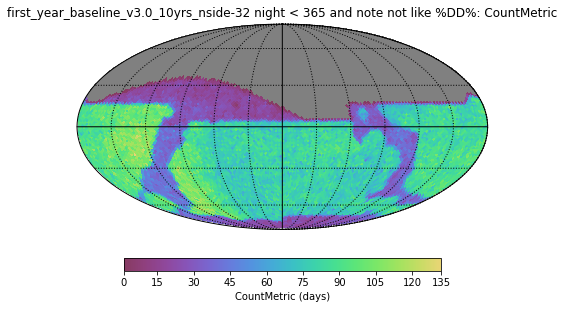

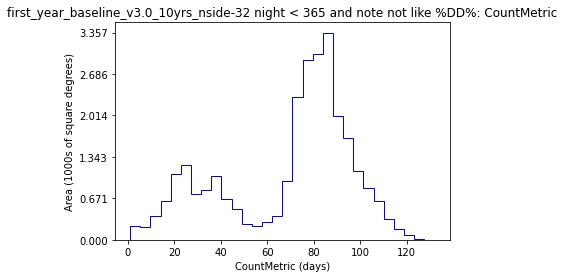

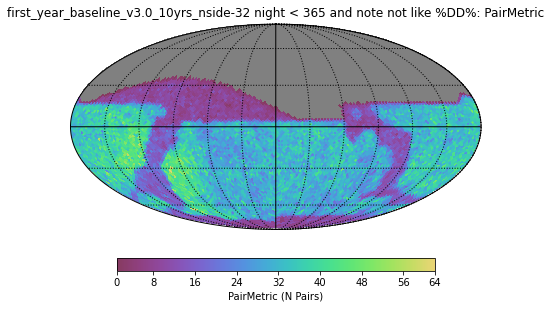

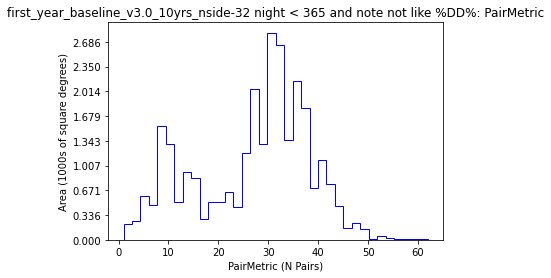

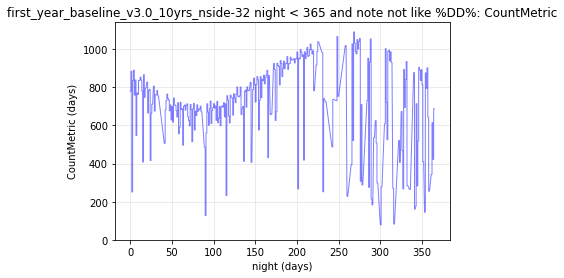

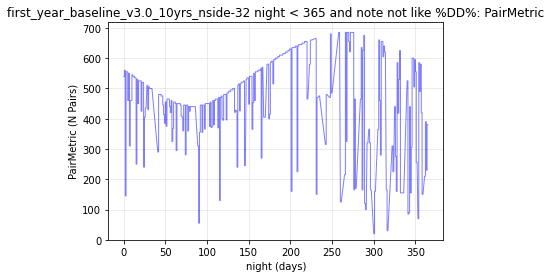

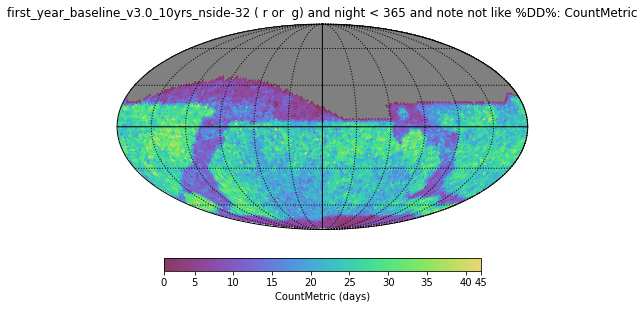

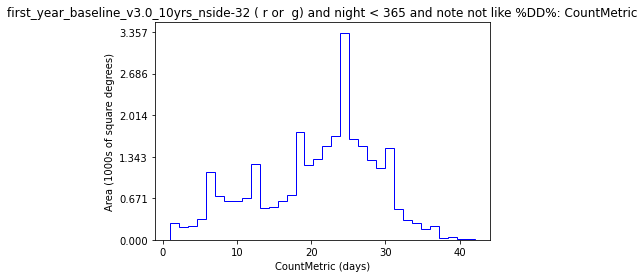

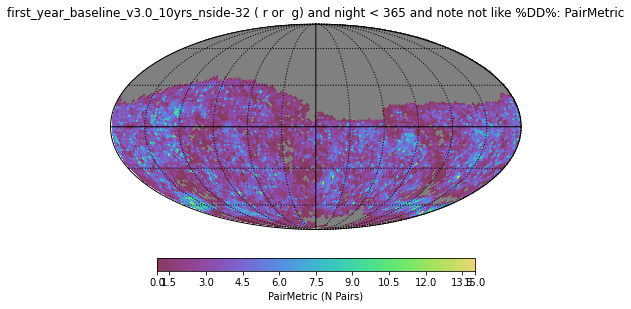

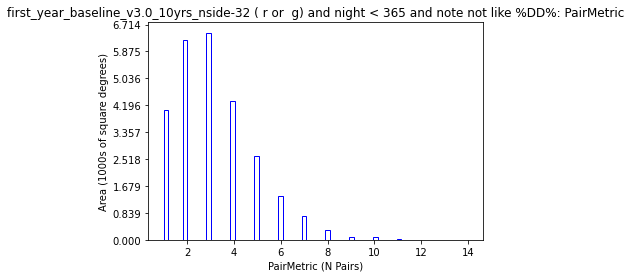

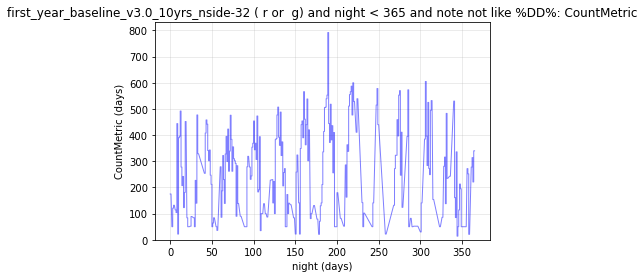

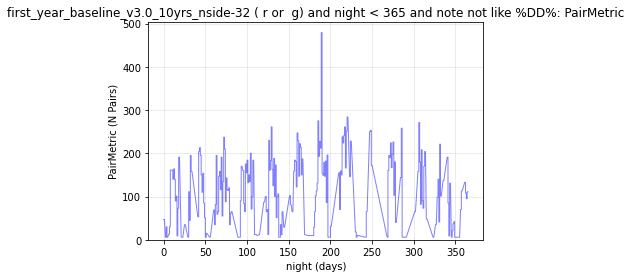

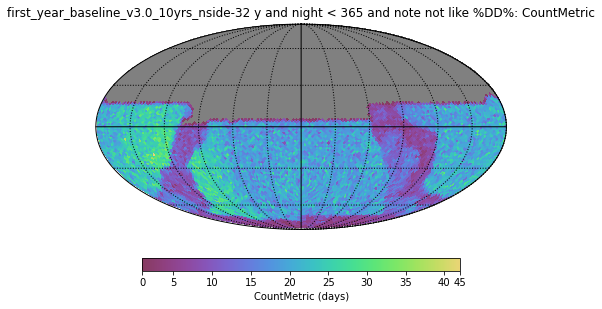

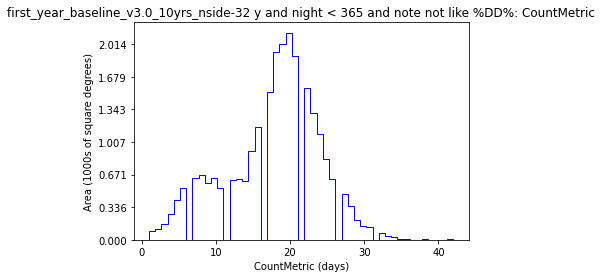

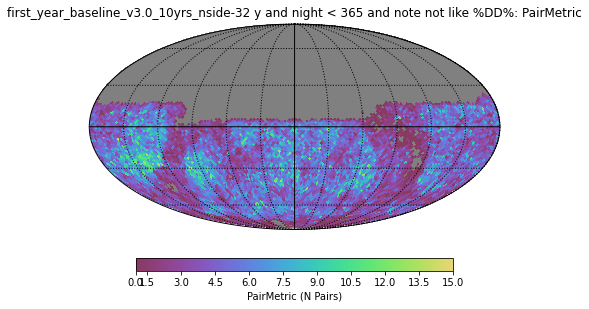

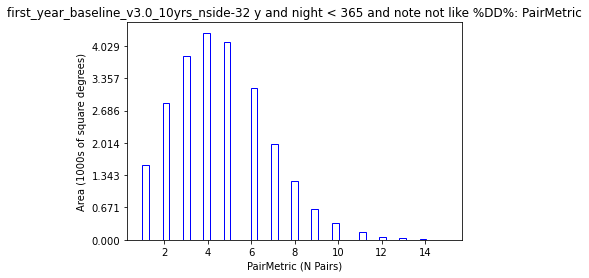

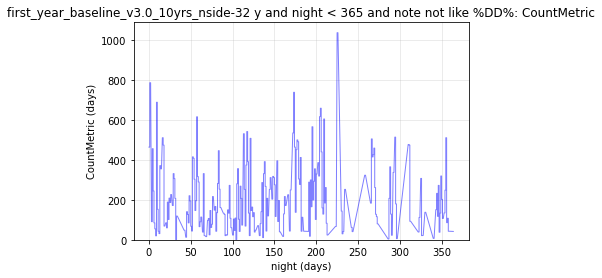

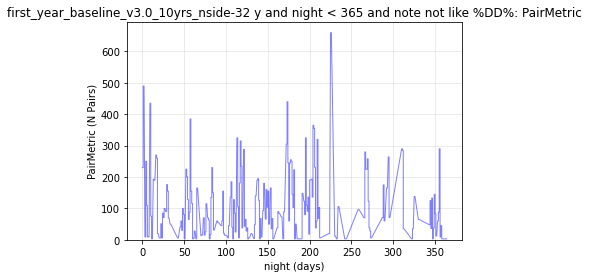

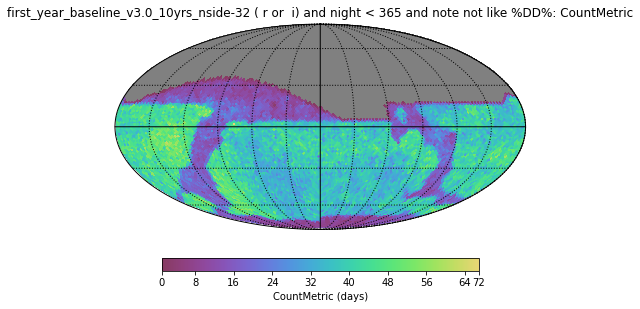

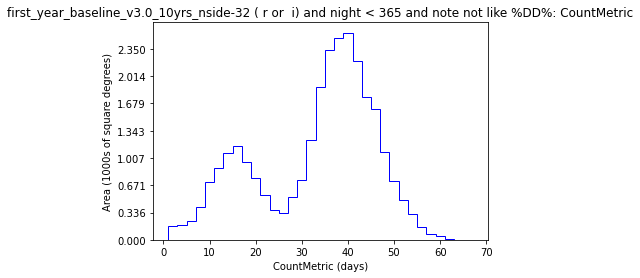

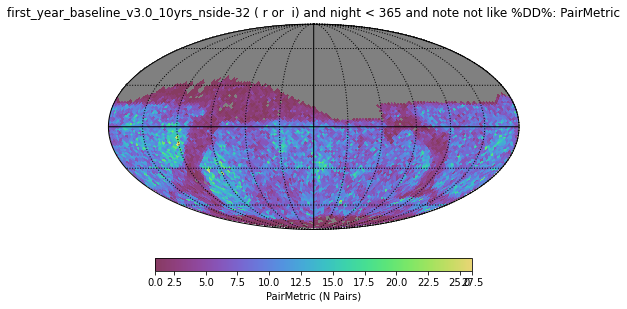

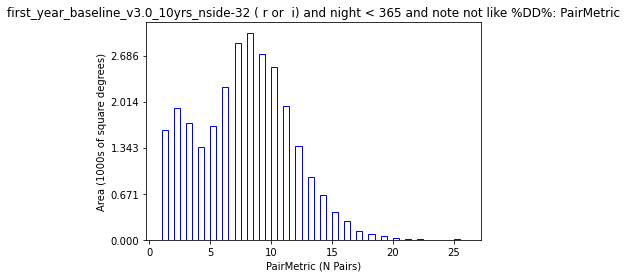

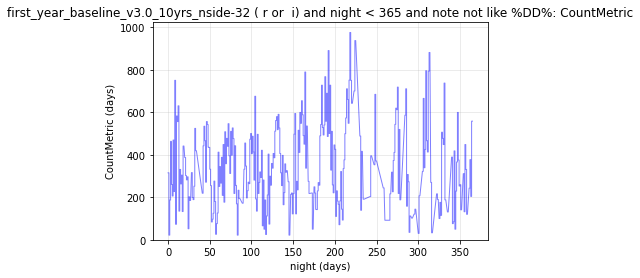

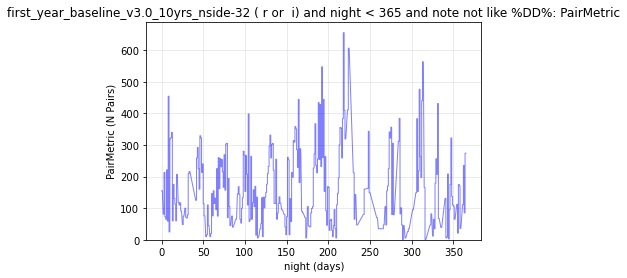

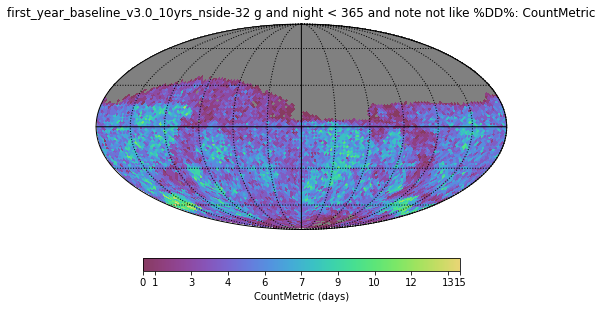

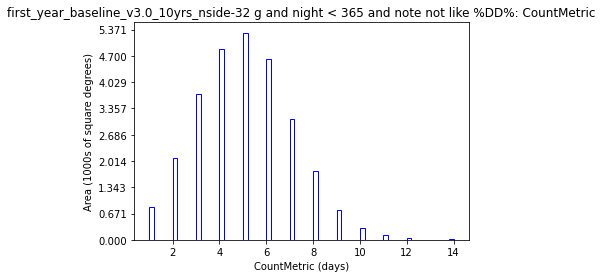

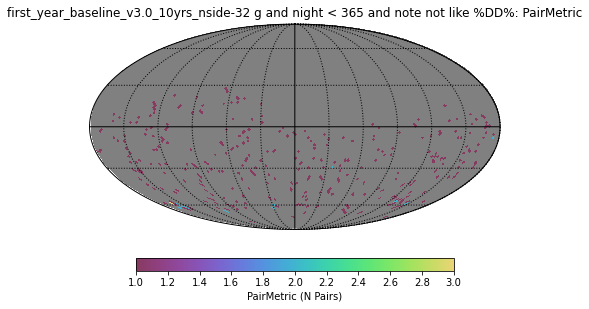

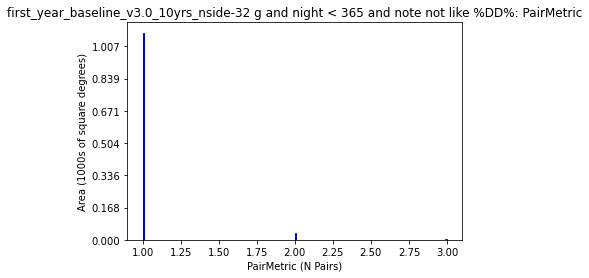

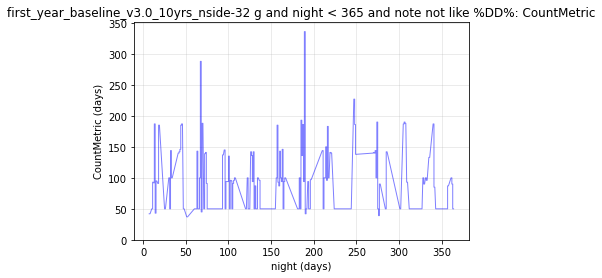

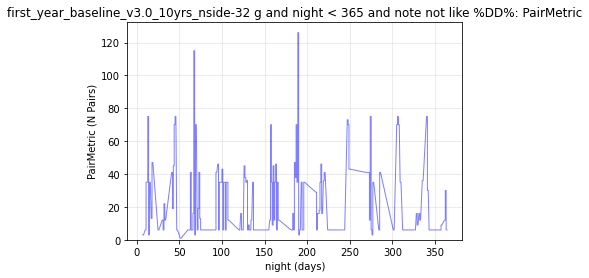

In [17]:
# Do regular metrics on the baseline, count visits and pairs

start = time.time()

slicer1 = s_hp # spatial slicer
slicer2 = s_t # time (night) slicer

t_data=night_max

_runName = "{}_nside-{}".format(runName,nside)

bl = []
summary_stats = [maf.MedianMetric()]

for filt in ["all","u","g","r","i","z","y",
                        "r_or_g","r_or_i","r_or_z"]:

# for filt in ["all"]:

    if filt=="all":
        sql = 'night <= {}'.format(t_data)+sqlDD
    elif "_or_" in filt:
        sql = '(filter = "r" or filter = "{}") and night <= {}'.format(filt.split("_or_")[-1],t_data)+sqlDD
    else:
        sql = 'filter = "{}" and night <= {}'.format(filt,t_data)+sqlDD

    # Run the regular metrics without templates
    metric = maf.CountMetric(col='night', metricName = "CountMetric")
    bl.append(maf.MetricBundle(metric, slicer1, sql, summaryMetrics=summary_stats, runName=_runName))

    metric = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName = "PairMetric")
    bl.append(maf.MetricBundle(metric, slicer1, sql, summaryMetrics=summary_stats, runName=_runName))
    
    # Run the time based metrics
    metric = maf.CountMetric(col='night', metricName = "CountMetric")
    bl.append(maf.MetricBundle(metric, slicer2, sql, summaryMetrics=summary_stats, runName=_runName))
    
    metric = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName = "PairMetric")
    bl.append(maf.MetricBundle(metric, slicer2, sql, summaryMetrics=summary_stats, runName=_runName))
    
mg = maf.MetricBundleGroup(bl, opsdb, outDir=save_dir)

mg.runAll()
mg.plotAll(closefigs=False)
    
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

In [18]:
# do metrics with templates for a spatial slicer

start = time.time()

slicer = s_hp

for template_timescale in tscales:

    _runName = "{}_tscale-{}_nside-{}".format(runName,template_timescale,nside)

    template_nights = template_timescales[str(template_timescale)]
    
    for i in range(1,len(template_nights)):
        
        t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
        t_template = template_nights[i-1] # this is the last date at which templates were generated
            
        print(template_timescale,t_template,t_data)

        bl = []
        summary_stats = [maf.MedianMetric()]

        for filt in ["all","u","g","r","i","z","y"]:

            if filt=="all":
                sql = 'night <= {}'.format(t_data)+sqlDD
            else:
                sql = 'filter = "{}" and night <= {}'.format(filt,t_data)+sqlDD

            # Our new metric that only counts things after templates have been generated
            metric = doAllTemplateMetrics(units='count', metricName = "doAllTemplateMetrics", 
                                             night_template_min = t_template)
            bl.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_stats, runName=_runName))
            
        mg = maf.MetricBundleGroup(bl, opsdb, outDir=save_dir)

        mg.runAll()
#             mg.plotAll(closefigs=False)
            
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

28 0 28
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint filter = "g" and night <= 28 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 928 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_28_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 28 and note not like "%DD%" for columns ['fiveSigmaDepth', 'see

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "z" and night <= 84 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 9276 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_z_and_night_lt_84_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 84 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 3994 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_84_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed

Found 88795 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_night_lt_140_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "r" and night <= 140 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 19520 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_r_and_night_lt_140_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "i" and night <= 140 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 21588 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemp

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
28 196 224
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 196, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint filter = "u" and night <= 224 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 6629 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_u_and_night_lt_224_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying tabl

Querying table None with constraint filter = "r" and night <= 280 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 39229 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_r_and_night_lt_280_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 280 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 12527 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_280_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 280 and note not like 

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 14096 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "z" and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 35629 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_z_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

Found 14795 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
112 0 112
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint filter = "g" and night <= 112 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 5371 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_g_and_night_lt_11

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 44591 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_y_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "r" and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 44815 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_r_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
C

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 168 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 4609 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_u_and_night_lt_168_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 168 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 8060 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_g_and_night_lt_168_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

Found 14795 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_g_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
447.16136407852173s (7.452689min or 0.124211hrs)


In [19]:
# run pair metrics with templates for a spatial slicer
# use all filters or filter pairs: r-g, r-i, r-z

start = time.time()

slicer = s_hp

for template_timescale in tscales:

    _runName = "{}_tscale-{}_nside-{}".format(runName,template_timescale,nside)

    template_nights = template_timescales[str(template_timescale)]
    
    for i in range(1,len(template_nights)):
        
        t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
        t_template = template_nights[i-1] # this is the last date at which templates were generated
            
        print(template_timescale,t_template,t_data)

        bl = []
        summary_stats = [maf.MedianMetric()]

        for filt in ["all","g","i","z"]:

            if filt=="all":
                sql = 'night <= {}'.format(t_data)+sqlDD
            else:
                sql = '(filter = "r" or filter = "{}") and night <= {}'.format(filt,t_data)+sqlDD

            # Our new metric that only counts things after templates have been generated
            metric = doPairTemplateMetrics(units='count', metricName = "doPairTemplateMetrics", 
                                             night_template_min = t_template)
            bl.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_stats, runName=_runName))
            
        mg = maf.MetricBundleGroup(bl, opsdb, outDir=save_dir)

        mg.runAll()
#             mg.plotAll(closefigs=False)
            
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

28 0 28
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint (filter = "r" or filter = "i") and night <= 28 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 8369 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_r_or_i_and_night_lt_28_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 28 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 19937 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
28 112 140
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint night <= 140 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 88795 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_night_lt_140_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint (filter = "r" or filter = "g") and night <= 140 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'obse

Found 63073 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_r_or_z_and_night_lt_224_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
28 224 252
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint (filter = "r" or filter = "z") and night <= 252 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 65958 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_r_or_z_and_night_lt_252_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table N

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 196211 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
28 336 364
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint (filter = "r" or filter = "i") and night <= 364 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'obs

Found 72813 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doPairTemplateMetrics_r_or_i_and_night_lt_224_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint (filter = "r" or filter = "z") and night <= 224 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 63073 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doPairTemplateMetrics_r_or_z_and_night_lt_224_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
112 224 336
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 224, seeing_ratio = 2.0, m5_range = 0.5
Querying tabl

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint (filter = "r" or filter = "g") and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 58911 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doPairTemplateMetrics_r_or_g_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'seeingFwhmEff', 'night', 'rotSkyPos', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 196211 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doPairTemplateMetrics_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics

# Load the saved template metric data and combine the chunks

In [20]:
start = time.time()

# glob filenames with pattern: runName, metricName
files = glob.glob("{}/*npz".format(save_dir))

# define list of metrics to load
metric_list = ["doAllTemplateMetrics_Count","doAllTemplateMetrics_Night",
              "doAllTemplateMetrics_DeltaNight",
               "doAllTemplateMetrics_SeeingTemplate","doAllTemplateMetrics_DepthTemplate",
              "doAllTemplateMetrics_NTemplate", "doPairTemplateMetrics_Pairs"]

# sql_list to get filters
filters = ["all","u","g","r","i","z","y","r_or_g","r_or_i","r_or_z"]

metric_dict = {}

for template_timescale in tscales:

    _runName = "{}_tscale-{}_nside-{}".format(runName,template_timescale,nside).replace(".","_")
    
    print(_runName)
    
    metric_dict[str(template_timescale)] = {}
            
    for metric in metric_list:
        
        print(metric)
        
        metric_dict[str(template_timescale)][metric] = {}
        
        for filt in filters:
            
            if metric == "doPairTemplateMetrics_Pairs" and (("or" not in filt) and ("all" not in filt)):
                continue

            print(filt)
            
            if filt=="all":
                _files = [x for x in files if (_runName in x) & (metric in x) 
                         & ~(("_u_".format(filt) in x)
                         | ("_g_".format(filt) in x)
                         | ("_r_".format(filt) in x)
                         | ("_i_".format(filt) in x)
                         | ("_z_".format(filt) in x)
                         | ("_y_".format(filt) in x))]
            else:
                _files = [x for x in files if (_runName in x) & (metric in x) & ("_{}_".format(filt) in x)]
            _files.sort() # sort to ensure files are in numerical order
            print(_files)
            print(len(_files))
            
            if len(_files)==0:
                print("NO FILES?")
                continue

            # Each metric was run on batches of visits, we therefore store a list of loaded files for each metric
            metric_bundle = []

            for x in _files:
                metric_bundle.append(maf.MetricBundle.load(x))


    #         # Slice points
    #         metric_slice = metric_bundle[0].slicer.slicePoints

            # retrieve all the masked arrays, each value corresponds to the metric value for some slice point
            data = [mb.metricValues.data for mb in metric_bundle]
            mask = [mb.metricValues.mask for mb in metric_bundle]
            metric_data = np.ma.array(data, mask=mask)

            if (metric=="doAllTemplateMetrics_Night") or \
            (metric=="doAllTemplateMetrics_DeltaNight") or \
            (metric=="doAllTemplateMetrics_NTemplate") or \
            (metric=="doAllTemplateMetrics_DtTemplate"):
                # find the min of all constituent metrics
                metric_vals = metric_data.min(axis=0)
            elif (metric=="doAllTemplateMetrics_SeeingTemplate") or (metric=="doAllTemplateMetrics_DepthTemplate"):
                # find the mean of the metrics
                metric_vals = metric_data.mean(axis=0)
            else:
                # find the sum of all constituent metrics
                metric_vals = metric_data.sum(axis=0)

            metric_vals.fill_value = np.nan

            metric_dict[str(template_timescale)][metric][filt] = metric_vals
        
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

first_year_baseline_v3_0_10yrs_tscale-28_nside-32
doAllTemplateMetrics_Count
all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_196_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_252_an

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_i_and_night_lt_112_and_note_not_like_DD_HEAL.npz

r_or_g
[]
0
NO FILES?
r_or_i
[]
0
NO FILES?
r_or_z
[]
0
NO FILES?
doAllTemplateMetrics_Night
all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_196_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_r_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
y
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_y_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_y_and_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_y_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_y_and_night_

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_g_and_night_lt_112_and_note_not_like_DD_HEA

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_z_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_z_and_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DeltaNight_z_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noD

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slic

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_SeeingTemplate_i_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_SeeingTemplate_i_and_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_SeeingTemplate_i_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_re

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_DepthTemplate_u_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yr

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
z
['remove_n

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_NTemplate_u_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_NTemplate_u_and_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_NTemplate_u_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_NTemplate_u_and_night_lt_196_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_NTemplate_u_and_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remo

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_NTemplate_i_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_ts

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r_or_g
[]
0
NO FILES?
r_or_i
[]
0
NO FILES?
r_or_z
[]
0
NO FILES?
doPairTemplateMetrics_Pairs
all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_night_

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r_or_z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_r_or_z_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_r_or_z_and_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doPairTemplateMetrics_Pairs_r_or_z

u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Night_u_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Night_u_and_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Night_u_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Night_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
g
['remove_no_template_results_

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DeltaNight_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix sli

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DepthTemplate_r_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DepthTemplate_r_and_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DepthTemplate_r_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_DepthTemplate_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
y
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_NTemplate_y_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_NTemplate_y_and_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_NTemplate_y_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_NTemplate_y_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer 

r
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_r_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_r_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_r_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_i_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetr

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
u
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_SeeingTemplate_u_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_SeeingTemplate_u_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_SeeingTemplate_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doA

i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_NTemplate_i_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_NTemplate_i_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_NTemplate_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_NTemplate_z_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_d

In [21]:
for x in metric_dict.keys():
    print(metric_dict[x].keys())
    for y in metric_dict[x].keys():
        print(len(metric_dict[x][y]))

dict_keys(['doAllTemplateMetrics_Count', 'doAllTemplateMetrics_Night', 'doAllTemplateMetrics_DeltaNight', 'doAllTemplateMetrics_SeeingTemplate', 'doAllTemplateMetrics_DepthTemplate', 'doAllTemplateMetrics_NTemplate', 'doPairTemplateMetrics_Pairs'])
7
7
7
7
7
7
4
dict_keys(['doAllTemplateMetrics_Count', 'doAllTemplateMetrics_Night', 'doAllTemplateMetrics_DeltaNight', 'doAllTemplateMetrics_SeeingTemplate', 'doAllTemplateMetrics_DepthTemplate', 'doAllTemplateMetrics_NTemplate', 'doPairTemplateMetrics_Pairs'])
7
7
7
7
7
7
4
dict_keys(['doAllTemplateMetrics_Count', 'doAllTemplateMetrics_Night', 'doAllTemplateMetrics_DeltaNight', 'doAllTemplateMetrics_SeeingTemplate', 'doAllTemplateMetrics_DepthTemplate', 'doAllTemplateMetrics_NTemplate', 'doPairTemplateMetrics_Pairs'])
7
7
7
7
7
7
4


first_year_baseline_v3_0_10yrs_nside-32 CountMetric all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


0.0 180.0 -180.0 180.0


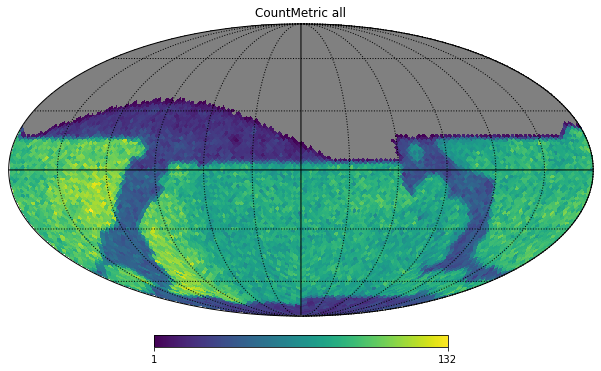

/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_89093/4185156844.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


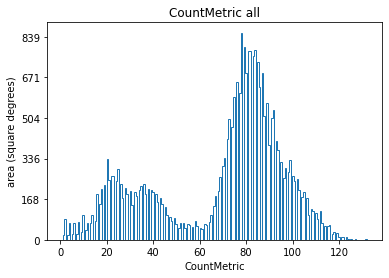

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric r_or_g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


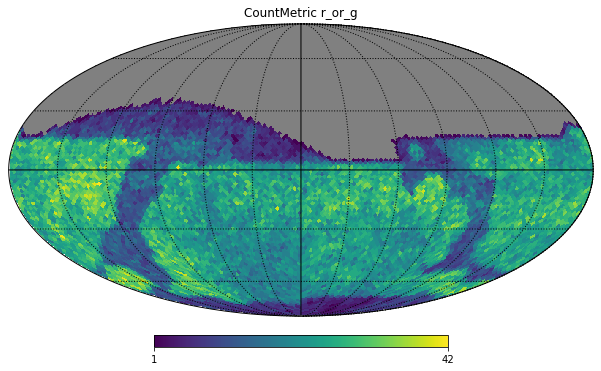

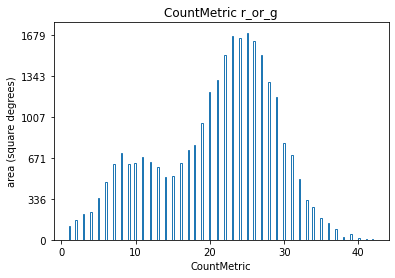

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric r_or_i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


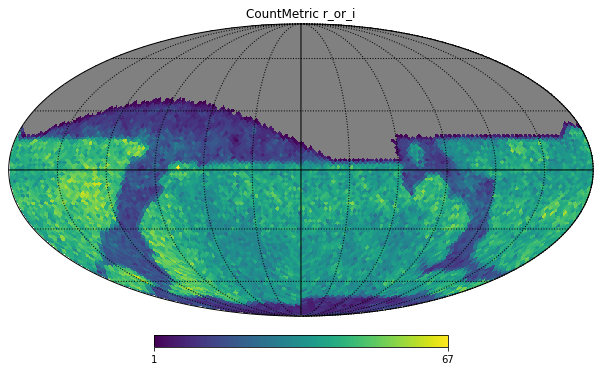

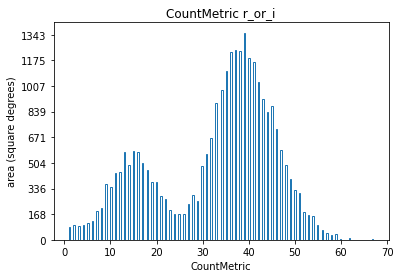

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 CountMetric r_or_z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


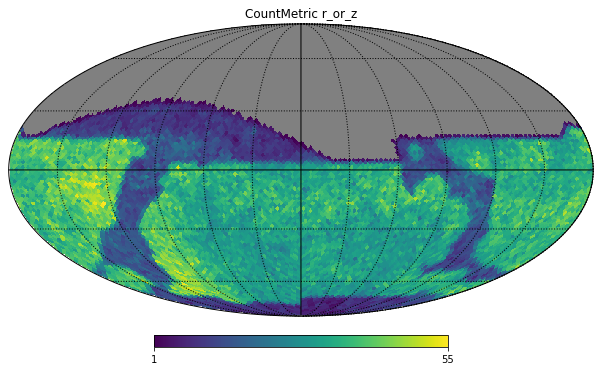

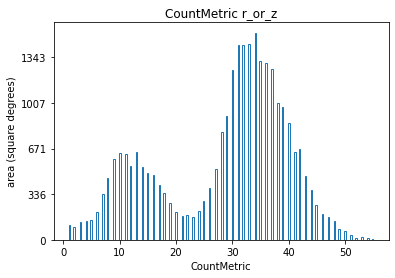

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric all
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


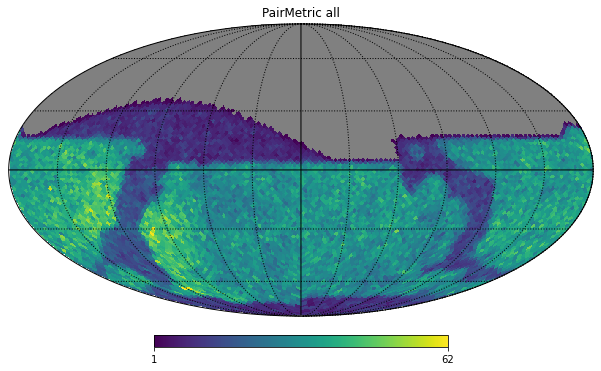

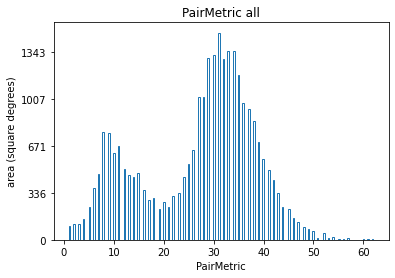

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_g
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


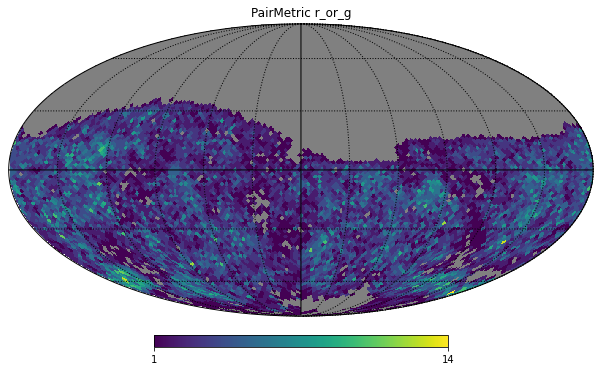

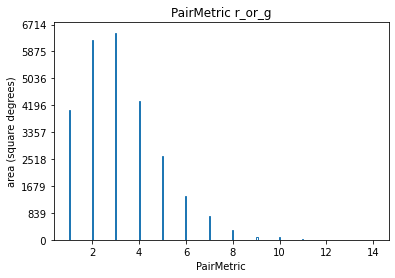

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_i
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_i_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


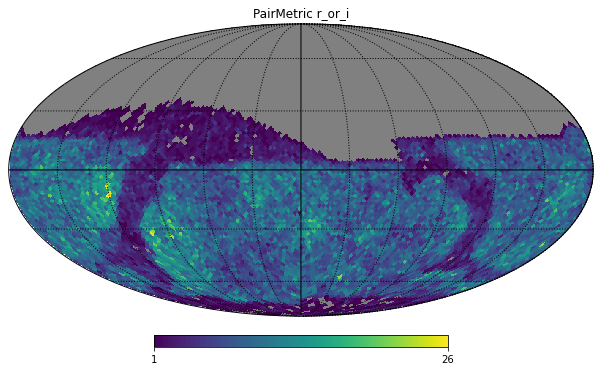

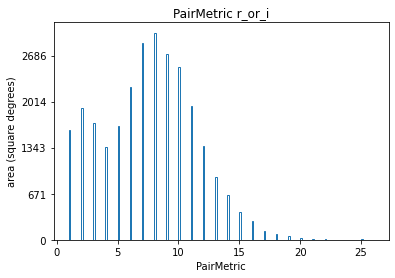

0.0 180.0 -180.0 180.0


first_year_baseline_v3_0_10yrs_nside-32 PairMetric r_or_z
['remove_no_template_results_32_noDD/first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_or_z_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


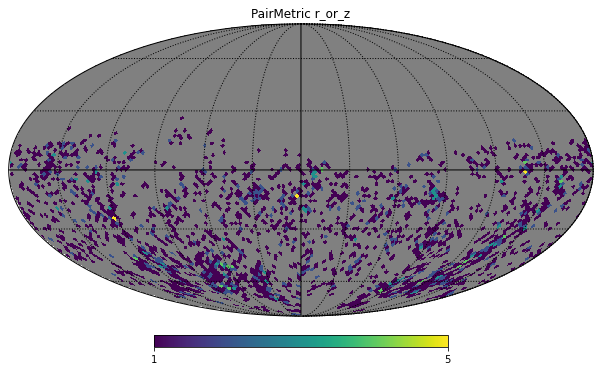

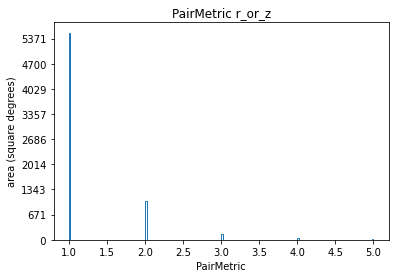

In [22]:
# load and plot the baseline metrics

# glob filenames with pattern: runName, metricName
files = glob.glob("{}/*npz".format(save_dir))

baseline_metric_list = ["CountMetric","PairMetric"]

# for template_timescale in tscales:
for template_timescale in ["28"]:
    for metric in baseline_metric_list:
        for filt in ["all","r_or_g","r_or_i","r_or_z"]:
                        
            _runName = "{}_nside-{}".format(runName,nside).replace(".","_")

            print(_runName,metric,filt)

            if filt=="all":
                _files = [x for x in files if ("_HEAL" in x) & (_runName in x) & (metric in x) 
                         & ~(("_u_".format(filt) in x)
                         | ("_g_".format(filt) in x)
                         | ("_r_".format(filt) in x)
                         | ("_i_".format(filt) in x)
                         | ("_z_".format(filt) in x)
                         | ("_y_".format(filt) in x))]
            else:
                _files = [x for x in files if ("_HEAL" in x) & (_runName in x) & (metric in x) & ("_{}_".format(filt) in x)]
            
            if len(_files)!=1:
                print("error")
                break
            print(_files)
            
            # load metric data
            _metric = maf.MetricBundle.load(_files[0])
            data = _metric.metricValues.data
            mask = _metric.metricValues.mask
            metric_data = np.ma.array(data, mask=mask, fill_value = np.nan)
            
            # plot skymap
            hp.mollview(metric_data, title="{} {}".format(metric,filt))
            hp.graticule()
            plt.show()
            
            # plot hist
            fig = plt.figure()
            gs = gridspec.GridSpec(1,1)
            ax1 = plt.subplot(gs[0,0])
            bins = 200
            pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

            n,b,p = ax1.hist(metric_data, bins = bins, histtype = "step")

            # scale the y axis to get sky area
            y_vals = ax1.get_yticks()
            ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])

            ax1.set_xlabel(metric)
            ax1.set_ylabel("area (square degrees)")

            plt.title("{} {}".format(metric,filt))

            plt.show()
        

0.0 180.0 -180.0 180.0


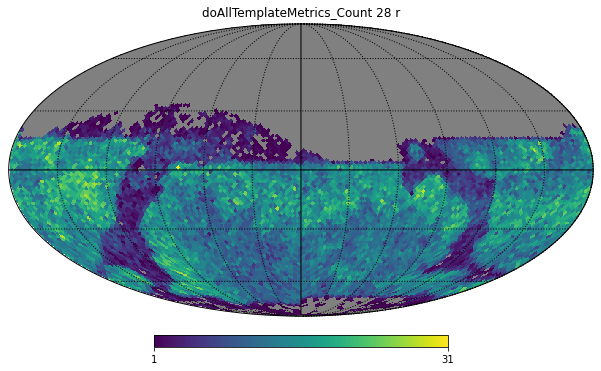

26249.748047624453


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_89093/134453219.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


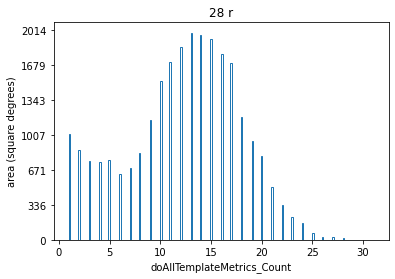

0.0 180.0 -180.0 180.0


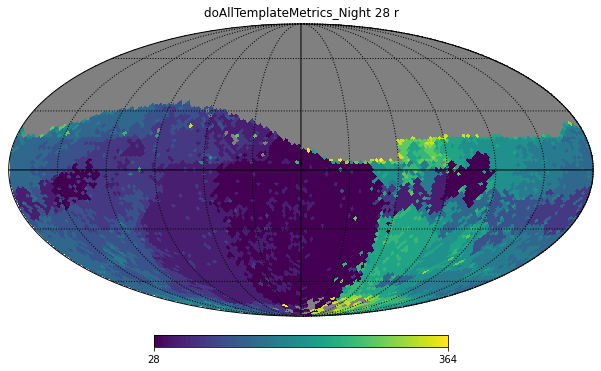

27367.687183045728


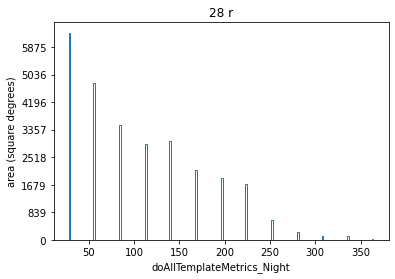

0.0 180.0 -180.0 180.0


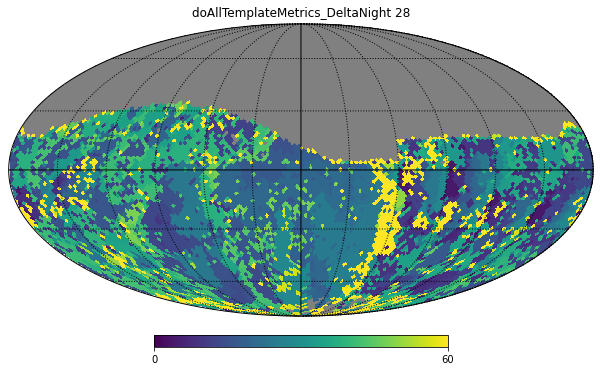

27367.687183045728


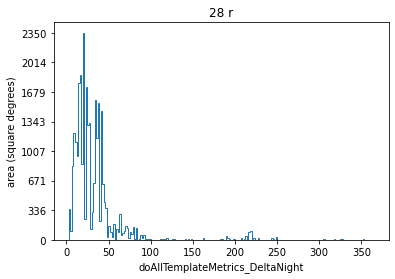

0.0 180.0 -180.0 180.0


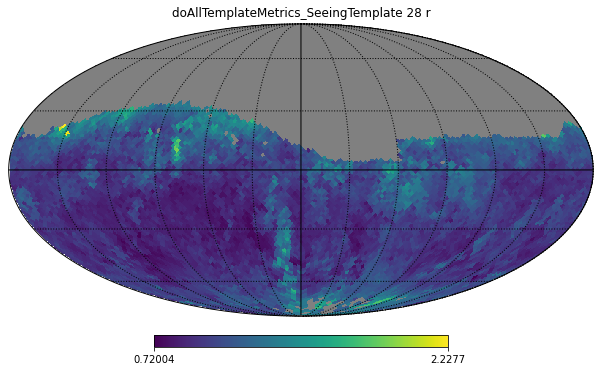

27367.687183045728


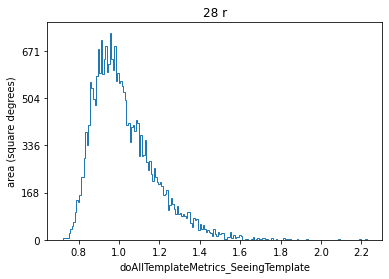

0.0 180.0 -180.0 180.0


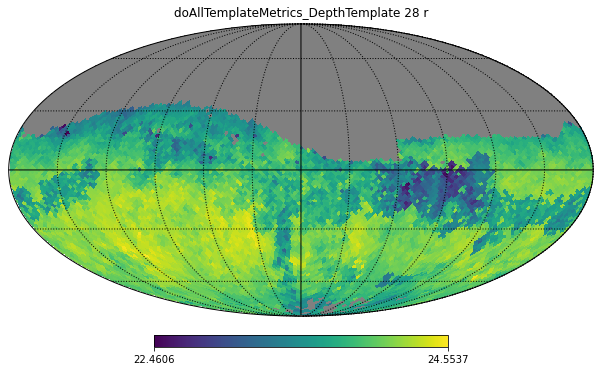

27367.687183045728


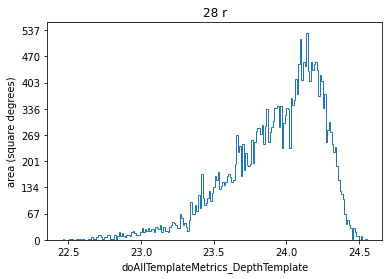

0.0 180.0 -180.0 180.0


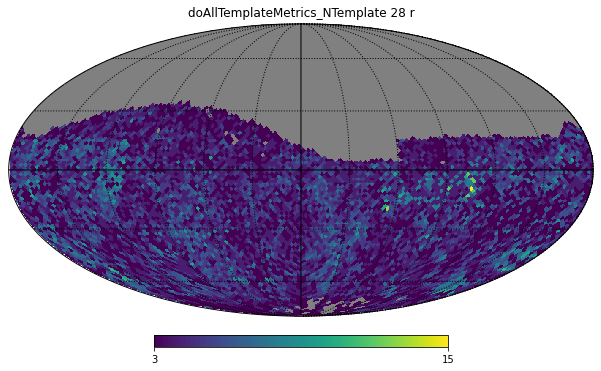

27367.687183045728


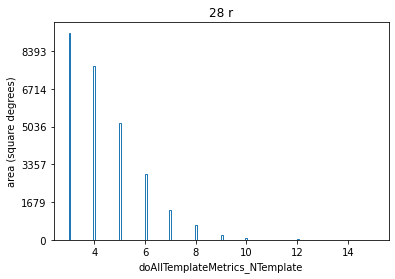

In [23]:
# plot the template metrics

filt = "r"
for m in metric_list:
    
    if "Pair" in m:
        continue
        
    for template_timescale in [28]:

        metric_plot = metric_dict[str(template_timescale)][m][filt]

        # skymap plot
        if m=="doAllTemplateMetrics_DeltaNight":
            # limit the colour scale here as there are a small number of healpixels with 60-365 days
            hp.mollview(metric_plot, title="{} {}".format(m,template_timescale), min=0, max=60)
        else:
            hp.mollview(metric_plot, title="{} {} {}".format(m,template_timescale,filt))
        hp.graticule()
        plt.show()
        
        # hist plot
        fig = plt.figure()
        gs = gridspec.GridSpec(1,1)
        ax1 = plt.subplot(gs[0,0])
        # bins = "auto"
        bins = 200
        pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

        n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

        # total area
        print(sum(n)*pix_area)

        # scale the y axis to get sky area
        y_vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])

        ax1.set_xlabel(m)
        ax1.set_ylabel("area (square degrees)")

        plt.title("{} {}".format(template_timescale,filt))

        plt.show()
            

0.0 180.0 -180.0 180.0


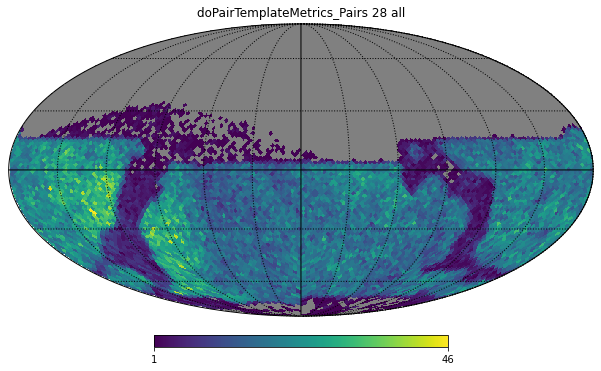

25870.387319989004


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_89093/2138071842.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


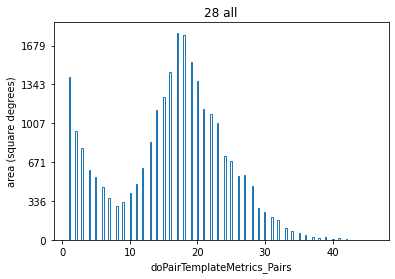

0.0 180.0 -180.0 180.0


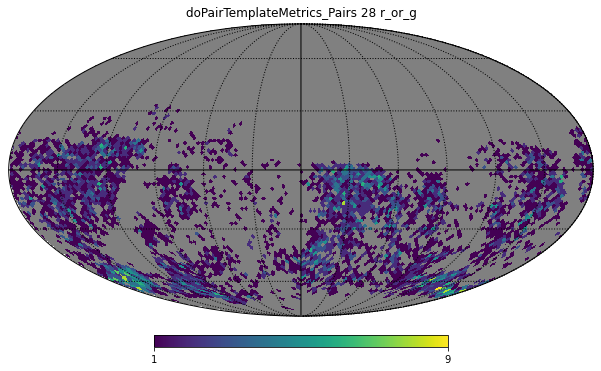

11206.248750859499


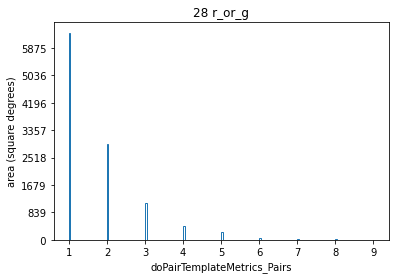

0.0 180.0 -180.0 180.0


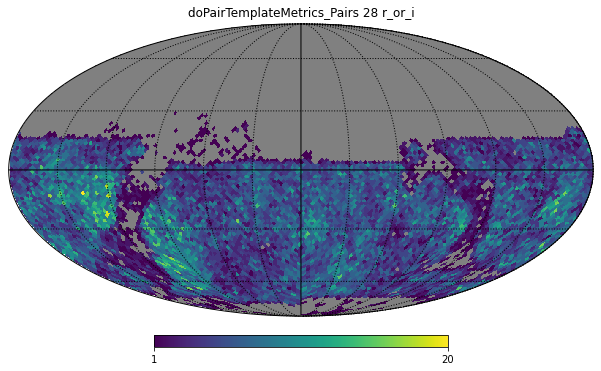

23271.934194415233


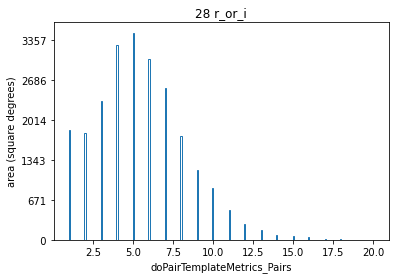

0.0 180.0 -180.0 180.0


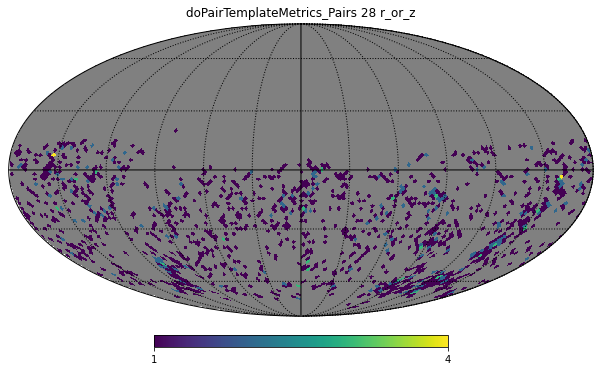

4559.043080787058


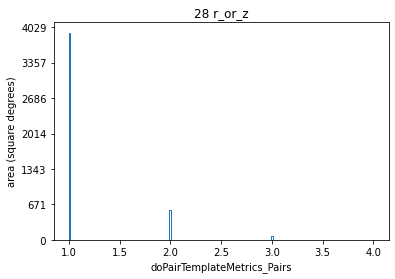

In [24]:
# plot the template pair metrics

m = "doPairTemplateMetrics_Pairs"

for filt in ["all","r_or_g","r_or_i","r_or_z"]:
    
    for template_timescale in [28]:

        metric_plot = metric_dict[str(template_timescale)][m][filt]

        hp.mollview(metric_plot, title="{} {} {}".format(m,template_timescale,filt))
        hp.graticule()
        plt.show()
        
        fig = plt.figure()
        gs = gridspec.GridSpec(1,1)
        ax1 = plt.subplot(gs[0,0])
        bins = 200
        pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees

        n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

        # total area
        print(sum(n)*pix_area)

        # scale the y axis to get sky area
        y_vals = ax1.get_yticks()
        ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])

        ax1.set_xlabel(m)
        ax1.set_ylabel("area (square degrees)")

        plt.title("{} {}".format(template_timescale,filt))

        plt.show()        

# Run the full remove template code on all date ranges

In [25]:
template_col = "npix_template"

start = time.time()

print(opsdb,nside)

_runName = "{}_nside-{}".format(runName,nside).replace(".","_")
templates_fname = "{}/{}_tscales-{}.json".format(save_dir,_runName,"-".join(str(x) for x in tscales))

if os.path.isfile(templates_fname):
    print("load {}".format(templates_fname))
    template_visits = json.load( open(templates_fname) )
else:
    template_visits = {}
    for template_timescale in tscales:

        n_visits = []
        obsIds = []
        template_frac_list = []

        template_nights = template_timescales[str(template_timescale)]

        for i in range(1,len(template_nights)):
            t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
            t_template = template_nights[i-1] # this is the last date at which templates were generated
            # select visits in chunk from original year 1 database
            data = maf.getSimData(opsdb, None, None,
                                  full_sql_query='select * from observations where night <= {}{};'.format(t_data,sqlDD))

            # convert to dataframe
            df = pd.DataFrame(data)

            # add new column
            df[template_col] = np.nan

            # write the dataframe to recarray
            data = df.to_records(index=False)
            
            # remove templates without visits
            data_w_templates = remove_no_templates(data, night_template_min = t_template, nside = nside,
                                                  template_col = template_col)
            n = data_w_templates.size
            n_visits.append(n)
            obsIds += list(data_w_templates["observationId"])
            print(t_data,t_template,n,data.size,len(obsIds))

            data_w_templates = remove_no_templates(data, night_template_min = t_template, nside = nside)
            template_frac_list+=list(data_w_templates[template_col])
                                
        # store the obsids and template_fraction of each timescale
        template_visits[str(template_timescale)] = {"n_visits":np.array(n_visits).tolist(),
                                              "template_nights":np.array(template_nights[1:]).tolist(),
                                              "npix_template":np.array(template_frac_list).tolist(),
                                                    "obsIds":np.array(obsIds).tolist()}
        
        print(template_frac_list[:50])
        print(sum(n_visits),len(template_frac_list))
#         break

    end = time.time()
    dt = end-start
    print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

    json.dump(template_visits, open(templates_fname, 'w' ) )

first_year_baseline_v3.0_10yrs.db 32
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0
28 0 0 19937 0
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0
night_template_min = 28, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 28
56 28 6759 34634 6759
night_template_min = 28, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 28
night_template_min = 56, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 56
84 56 11264 53126 18023
night_template_min = 56, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 56
night_template_min = 84, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 84
112 84 9624 69176 27647
night_template_min = 84, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 84
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112
140 112 13715 88795 41362
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112
night_templa

In [26]:
# save the redacted database for each timescale
# select visits in chunk from original year 1 database
df_data = df_year1.copy()
print(len(df_data))

for template_timescale in tscales:
    
    df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(template_timescale)]["obsIds"])]
    print(template_timescale, len(df_data_w_templates))
    
    # Insert a column for fraction template coverage
    # keep only visits with a template fractional coverage greater than some number (>0.9?)
    df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]
    
    fname = "{}/visit_cut_t-{}d_nside-{}.db".format(save_dir,template_timescale,nside)
    print(fname)

    # open up a connection to a new database
    conn = sqlite3.connect(fname)
    # save reduced visit dataframe to sql
    df_data_w_templates.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()

216378
28 141354
remove_no_template_results_32_noDD/visit_cut_t-28d_nside-32.db


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_89093/3609334197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]


112 91207
remove_no_template_results_32_noDD/visit_cut_t-112d_nside-32.db


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_89093/3609334197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]


168 70382
remove_no_template_results_32_noDD/visit_cut_t-168d_nside-32.db


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_89093/3609334197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]


In [27]:
template_visits.keys()

dict_keys(['28', '112', '168'])

28 0.5619154746239937
112 0.5559222428103107
168 0.5581398653064704


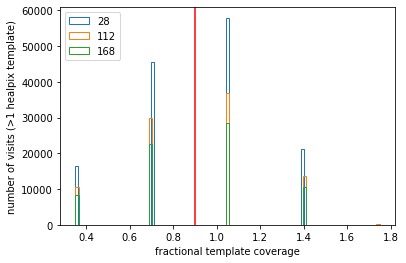

In [28]:
# plot the fractional template coverage for each visit

x_plot = "npix_template"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

for tscale in tscales:
    x = template_visits[str(tscale)][x_plot]/n_pix
    ax1.hist(x,bins = "auto", histtype = "step", label = tscale)
    print(tscale,len(x[x>=frac])/len(x))

ax1.axvline(frac,c="r")

ax1.set_xlabel("fractional template coverage")
ax1.set_ylabel("number of visits (>1 healpix template)")
ax1.legend(loc = "upper left")

# fname = "npix_template_hist.png"
# plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")
    
plt.show()

In [29]:
template_visits.keys()

dict_keys(['28', '112', '168'])

In [30]:
df_data_w_templates

observationId     fieldRA   fieldDec  observationStartMJD  \
111987         111987  122.857107 -19.753221         60386.994016   
111988         111988  121.806240 -16.793070         60386.994473   
111989         111989  124.724531 -17.182173         60386.994922   
111990         111990  125.831336 -20.122816         60386.995375   
111991         111991  126.981477 -23.057890         60386.995832   
...               ...         ...        ...                  ...   
216367         216367  321.835622 -17.700427         60583.100835   
216368         216368  325.039530 -17.773464         60583.101264   
216369         216369  317.893060 -22.770290         60583.101850   
216373         216373  313.150514 -33.400167         60583.103719   
216374         216374  311.896346 -30.501156         60583.104153   

        flush_by_mjd  visitExposureTime filter   rotSkyPos  rotSkyPos_desired  \
111987  60387.022645               30.0      i  196.136594         196.136594   
111988  60387.022645               30.0      i  203.260475         203.260475   
111989  60387.022645               30.0      i  199.309465         199.309465   
111990  60387.022645               30.0      i  192.767297         192.767297   
111991  60387.022645               30.0      i  185.938461         185.938461   
...              ...                ...    ...         ...                ...   
216367  60583.135416               30.0      u  200.510258         200.510258   
216368  60583.135416               30.0      u  191.355930         191.355930   
216369  60583.135416               30.0      u  222.678096         222.678096   
216373  60583.135416               30.0      u  263.368952         263.368952   
216374  60583.135416               30.0      u  252.817162         252.817162   

        numExposures  ...       sunRA    sunDec      moonRA    moonDec  \
111987             2  ...  357.742854 -0.978282   98.044864  29.243533   
111988             2  ...  357.743271 -0.978102   98.048790  29.243187   
111989             2  ...  357.743681 -0.977924   98.052649  29.242844   
111990             2  ...  357.744095 -0.977745   98.056550  29.242494   
111991             2  ...  357.744512 -0.977564   98.060483  29.242137   
...              ...  ...         ...       ...         ...        ...   
216367             1  ...  186.500097 -2.808967  160.521681  11.202930   
216368             1  ...  186.500484 -2.809133  160.528396  11.200622   
216369             1  ...  186.501014 -2.809361  160.537579  11.197468   
216373             1  ...  186.502703 -2.810087  160.566853  11.187431   
216374             1  ...  186.503096 -2.810255  160.573656  11.185103   

        moonDistance  solarElong  moonPhase  cummTelAz  scripted_id  \
111987     54.528753  122.378678  55.255662  65.047562            0   
111988     51.434034  122.087094  55.257323  56.858696            0   
111989     53.087134  124.720639  55.258956  62.334817            0   
111990     56.162493  124.977231  55.260607  70.103810            0   
111991     59.242827  125.115694  55.262271  78.332869            0   
...              ...         ...        ...        ...          ...   
216367    160.789717  131.441201  16.331052  23.610469            0   
216368    163.638125  134.252427  16.327442  32.005494            0   
216369    155.497469  126.155108  16.322505   2.511699            0   
216373    146.491284  118.081577  16.306773 -33.962407            0   
216374    147.142910  118.265113  16.303118 -25.645576            0   

        npix_template  
111987            2.0  
111988            3.0  
111989            2.0  
111990            2.0  
111991            2.0  
...               ...  
216367            4.0  
216368            3.0  
216369            1.0  
216373            1.0  
216374            1.0  

[70382 rows x 45 columns]

In [31]:
len(template_visits[str(template_timescale)]["obsIds"])

70382

In [32]:
len(df_data_w_templates),len(template_visits[str(template_timescale)]["npix_template"])

(70382, 70382)

In [33]:
df_data_w_templates[~pd.isnull(df_data_w_templates["npix_template"])]

observationId     fieldRA   fieldDec  observationStartMJD  \
111987         111987  122.857107 -19.753221         60386.994016   
111988         111988  121.806240 -16.793070         60386.994473   
111989         111989  124.724531 -17.182173         60386.994922   
111990         111990  125.831336 -20.122816         60386.995375   
111991         111991  126.981477 -23.057890         60386.995832   
...               ...         ...        ...                  ...   
216367         216367  321.835622 -17.700427         60583.100835   
216368         216368  325.039530 -17.773464         60583.101264   
216369         216369  317.893060 -22.770290         60583.101850   
216373         216373  313.150514 -33.400167         60583.103719   
216374         216374  311.896346 -30.501156         60583.104153   

        flush_by_mjd  visitExposureTime filter   rotSkyPos  rotSkyPos_desired  \
111987  60387.022645               30.0      i  196.136594         196.136594   
111988  60387.022645               30.0      i  203.260475         203.260475   
111989  60387.022645               30.0      i  199.309465         199.309465   
111990  60387.022645               30.0      i  192.767297         192.767297   
111991  60387.022645               30.0      i  185.938461         185.938461   
...              ...                ...    ...         ...                ...   
216367  60583.135416               30.0      u  200.510258         200.510258   
216368  60583.135416               30.0      u  191.355930         191.355930   
216369  60583.135416               30.0      u  222.678096         222.678096   
216373  60583.135416               30.0      u  263.368952         263.368952   
216374  60583.135416               30.0      u  252.817162         252.817162   

        numExposures  ...       sunRA    sunDec      moonRA    moonDec  \
111987             2  ...  357.742854 -0.978282   98.044864  29.243533   
111988             2  ...  357.743271 -0.978102   98.048790  29.243187   
111989             2  ...  357.743681 -0.977924   98.052649  29.242844   
111990             2  ...  357.744095 -0.977745   98.056550  29.242494   
111991             2  ...  357.744512 -0.977564   98.060483  29.242137   
...              ...  ...         ...       ...         ...        ...   
216367             1  ...  186.500097 -2.808967  160.521681  11.202930   
216368             1  ...  186.500484 -2.809133  160.528396  11.200622   
216369             1  ...  186.501014 -2.809361  160.537579  11.197468   
216373             1  ...  186.502703 -2.810087  160.566853  11.187431   
216374             1  ...  186.503096 -2.810255  160.573656  11.185103   

        moonDistance  solarElong  moonPhase  cummTelAz  scripted_id  \
111987     54.528753  122.378678  55.255662  65.047562            0   
111988     51.434034  122.087094  55.257323  56.858696            0   
111989     53.087134  124.720639  55.258956  62.334817            0   
111990     56.162493  124.977231  55.260607  70.103810            0   
111991     59.242827  125.115694  55.262271  78.332869            0   
...              ...         ...        ...        ...          ...   
216367    160.789717  131.441201  16.331052  23.610469            0   
216368    163.638125  134.252427  16.327442  32.005494            0   
216369    155.497469  126.155108  16.322505   2.511699            0   
216373    146.491284  118.081577  16.306773 -33.962407            0   
216374    147.142910  118.265113  16.303118 -25.645576            0   

        npix_template  
111987            2.0  
111988            3.0  
111989            2.0  
111990            2.0  
111991            2.0  
...               ...  
216367            4.0  
216368            3.0  
216369            1.0  
216373            1.0  
216374            1.0  

[70382 rows x 45 columns]

# The following figures show an overestimate (visits that have >=1 healpix with template)
i.e. does not necessarily have sufficient template coverage over the whole footprint

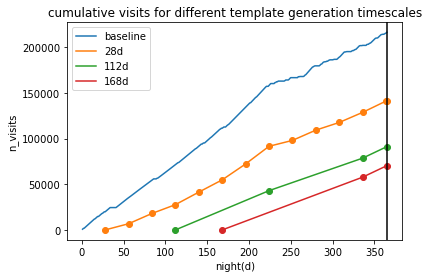

In [34]:
# plot the (cumulative) number of visits with templates as a function of survey night
# we just use the total number of visits that was recorded at the end of each template gen night
# i.e. we do not consider the count of visits on nights between template generation

# different lines show the effect of generating templates on different timescales

x_plot = "night(d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# plot year 1 baseline
counts, bins = np.histogram(df_year1["night"], bins=nights)
ax1.plot(bins[1:], counts.cumsum(), label = "baseline")

# plot each template generation timescale
for i,t in enumerate(tscales):
    
    ax1.plot(np.array(template_visits[str(t)]["template_nights"]),
             np.array(template_visits[str(t)]["n_visits"]).cumsum(),
             label = "{}d".format(t),c="C{}".format(i+1))
    ax1.scatter(np.array(template_visits[str(t)]["template_nights"]),
               np.array(template_visits[str(t)]["n_visits"]).cumsum(),
               c="C{}".format(i+1))

ax1.legend()
ax1.axvline(night_max,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.title("cumulative visits for different template generation timescales")

# fname = "n_visits_by_night.png"
# plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show()

In [35]:
# prin the total number of visits at the end of year 1 for each timescale
for t in tscales:
    print(t, sum(template_visits[str(t)]["n_visits"]))

28 141354
112 91207
168 70382


# mask the visit database to get a more realistic number of useful visits
This will be an underestimate compared to analysing each healpixel directly

In [36]:
n_pix

2.8595474464675097

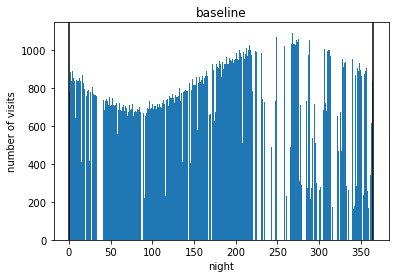

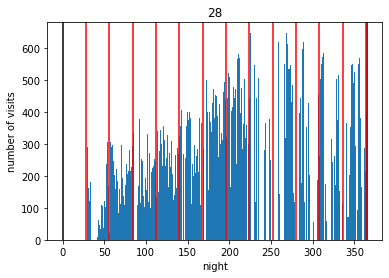

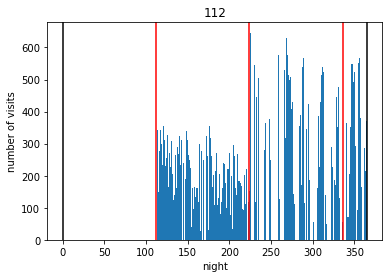

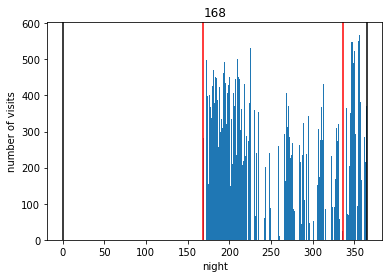

In [37]:
# distribution of visits with templates by night
x_plot = "night"
bins = nights
    
for i,tscale in enumerate(["baseline"] + tscales):
    
    if tscale!="baseline":
        df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(tscale)]["obsIds"])]
#         print(sys.getsizeof(df_data_w_templates))
        df_plot = df_data_w_templates
        # mask based on some fraction
        mask = template_visits[str(tscale)]["npix_template"]>=(frac*n_pix)
        df_plot = df_plot[mask]
    else: # use the baseline
        df_plot = df_year1

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    ax1.hist(df_plot[x_plot],bins=bins)

    ax1.axvline(0,c="k")
    ax1.axvline(night_max,c="k")

    if tscale!="baseline":
        for t in np.arange(tscale,night_max+tscale,tscale):
            if t>night_max:
                continue
            ax1.axvline(t,c="r", label = "template")

    ax1.set_xlabel(x_plot)
    ax1.set_ylabel("number of visits")

    plt.title(tscale)

    plt.show()

In [38]:
# repeat the above plot but with cumsum to get total visits as function of time

216378
141354
[ 28  56  84 112 140 168 196 224 252 280 308 336 364 365] 14
[    0  2730  8459 13577 20737 28210 38030 48978 53160 59898 64738 71605
 79031 79429] 14
91207
[112 224 336 365] 4
[    0 22092 42906 50704] 4
70382
[168 336 365] 3
[    0 31485 39283] 3


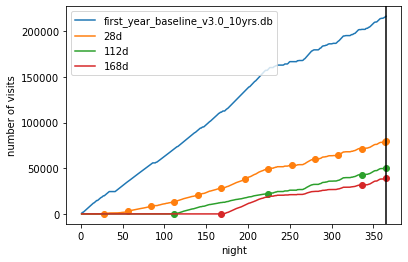

In [39]:
# distribution of visits with templates by night
# this is an underestimate as we are only selecting visits above a certain fraction

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])
    
total_counts = {}

# plot year 1 baseline
counts, bins = np.histogram(df_year1["night"], bins=nights)
ax1.plot(bins[1:], counts.cumsum(), label = year1_fname)
print(len(df_year1))

total_counts["baseline"] = counts.cumsum()[-1]

for i,tscale in enumerate(tscales):
    
    df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(tscale)]["obsIds"])]
    print(len(df_data_w_templates))
    
    x_plot = "night"
    df_plot = df_data_w_templates
    bins = nights

    # mask based on some template coverage fraction
    mask = template_visits[str(tscale)]["npix_template"]>=(frac*n_pix)
    df_plot = df_plot[mask]
    
    counts, bins = np.histogram(df_plot[x_plot], bins=nights)
    ax1.plot(bins[1:], counts.cumsum(), label = "{}d".format(tscale),
            c = "C{}".format(i+1))
    
    template_nights = np.array(template_visits[str(tscale)]["template_nights"])
    template_night_count = counts.cumsum()[np.isin(bins[1:],template_nights)]
    print(template_nights,len(template_nights))
    print(template_night_count,len(template_night_count))
    ax1.scatter(template_nights,template_night_count,c = "C{}".format(i+1))

    total_counts[str(tscale)] = counts.cumsum()[-1]

ax1.axvline(night_max,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel("number of visits")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

plt.show()

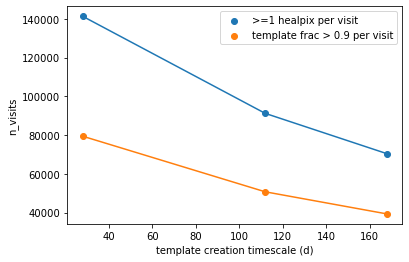

In [40]:
# plot number of visits (at end of year 1) vs template timescale
    
x_plot = "template creation timescale (d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

counts1 = np.array([sum(template_visits[str(t)]["n_visits"]) for t in tscales])
ax1.plot(tscales, counts1)
ax1.scatter(tscales, counts1, label = ">=1 healpix per visit")

counts2 = np.array([total_counts[str(t)] for t in tscales])
ax1.plot(tscales, counts2)
ax1.scatter(tscales, counts2, label = "template frac > {} per visit".format(frac))

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

ax1.legend()

plt.show()

In [41]:
# compare the fractional difference to the histogram of template fractional coverage above
counts2/counts1

array([0.56191547, 0.55592224, 0.55813987])